# Imprtant Library

In [4]:
# Standard libraries
import os

# Data manipulation and processing
import pandas as pd
import re

# Web scraping
from bs4 import BeautifulSoup

# Deep learning
import torch
from torch.utils.data import Dataset

# Transformers library
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import EarlyStoppingCallback
from transformers import pipeline

# Model evaluation and data splitting
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


# Setting Environment

In [5]:
# Disable symlink warning
os.environ['HF_HUB_DISABLE_SYMLINKS_WARNING'] = '1'

# Data Preprocessing && Cleaning

In [6]:
# Load and preprocess data
df = pd.read_csv('Data/Financial News.csv', delimiter=',', encoding='latin-1')
df.head()

,neutral,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing ."
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


In [7]:
# Rename column
df = df.rename(columns={'neutral': 'sentiment', 'According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .': 'Message'})
df.head()

,sentiment,Message
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


In [8]:
# Data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4845 entries, 0 to 4844
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  4845 non-null   object
 1   Message    4845 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB


In [9]:
# Convert sentiment labels to numeric
sentiment = {'positive': 0, 'neutral': 1, 'negative': 2}
df.sentiment = df.sentiment.map(sentiment)

In [10]:
# Text cleaning
def cleanText(text):
    if isinstance(text, str):
        # Process text with BeautifulSoup
        try:
            text = BeautifulSoup(text, "lxml").text
        except MarkupResemblesLocatorWarning:
            pass
        # Remove patterns like URLs
        text = re.sub(r'\|\|\|', ' ', text)
        text = re.sub(r'http\S+', '<URL>', text)
        # Text to lowercase
        text = text.lower()
        # Remove punctuation and non-alphabetic characters
        text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

In [11]:
df['Message'] = df['Message'].apply(cleanText)
df['Message'][5]

<ipython-input-10-b0ae138a8b30>:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").text


'for the last quarter of   componenta s net sales doubled to eurm from eurm for the same period a year earlier  while it moved to a zero pretax profit from a pretax loss of eurm '

# Data Visualization

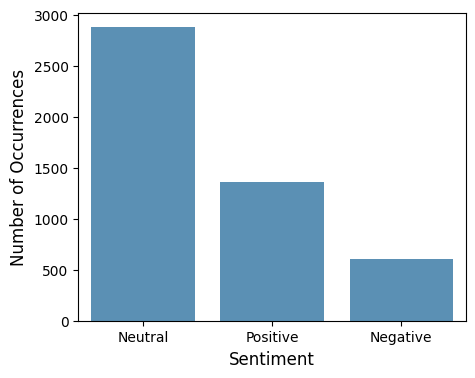

In [12]:
# Sentiment dictionary
sentiment = {'Positive': 0, 'Neutral': 1, 'Negative': 2}

# Reversing the sentiment
sentiment_reversed = {v: k for k, v in sentiment.items()}

# Counting the occurrences of each sentiment
cnt_pro = df['sentiment'].value_counts()

# Mapping the indices
cnt_pro.index = cnt_pro.index.map(sentiment_reversed)

# Plotting the bar chart
plt.figure(figsize=(5, 4))
sns.barplot(x=cnt_pro.index, y=cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Sentiment', fontsize=12)
plt.show()


# Data splitting

In [13]:
# Split data
train_texts, test_texts, train_labels, test_labels = train_test_split(df['Message'].tolist(), df['sentiment'].tolist(), test_size=0.2, random_state=42)

# Model Fine-tuning and Evaluation

In [15]:
# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to encode data
def encode_data(texts, labels):
    encodings = tokenizer(texts, truncation=True, padding=True)
    inputs = torch.tensor(encodings['input_ids'])
    masks = torch.tensor(encodings['attention_mask'])

    # Handle labels properly if they are tensors
    if isinstance(labels, torch.Tensor):
        labels = labels.clone().detach()
    else:
        labels = torch.tensor(labels)

    return inputs, masks, labels

# Encode data
train_inputs, train_masks, train_labels = encode_data(train_texts, train_labels)
test_inputs, test_masks, test_labels = encode_data(test_texts, test_labels)

# Print encoded data shapes as a sanity check
print(train_inputs.shape, train_masks.shape, train_labels.shape)
print(test_inputs.shape, test_masks.shape, test_labels.shape)


torch.Size([3876, 74]) torch.Size([3876, 74]) torch.Size([3876])
torch.Size([969, 70]) torch.Size([969, 70]) torch.Size([969])


In [16]:
# Create Dataset class
class CustomDataset(Dataset):
    def __init__(self, inputs, masks, labels):
        self.inputs = inputs
        self.masks = masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {'input_ids': self.inputs[idx], 'attention_mask': self.masks[idx], 'labels': self.labels[idx]}

train_dataset = CustomDataset(train_inputs, train_masks, train_labels)
test_dataset = CustomDataset(test_inputs, test_masks, test_labels)


In [17]:
# Define model and training arguments
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=7,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.1,  # Increased for regularization
    logging_dir='./logs',
    logging_steps=7,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    lr_scheduler_type='linear',
    load_best_model_at_end=True,
    metric_for_best_model = 'eval_loss',
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
# Define metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [19]:
# Train the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=1)]
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.308900,0.509472,0.822497,0.814518,0.831657,0.822497
2,0.282200,0.425196,0.836945,0.835086,0.835965,0.836945
3,0.337700,0.573077,0.833849,0.831573,0.833196,0.833849


TrainOutput(global_step=729, training_loss=0.46450555376933356, metrics={'train_runtime': 204.9944, 'train_samples_per_second': 132.355, 'train_steps_per_second': 8.298, 'total_flos': 442190876521968.0, 'train_loss': 0.46450555376933356, 'epoch': 3.0})

In [20]:
# Evaluate the model
results = trainer.evaluate()
print(results)

{'eval_loss': 0.42519640922546387, 'eval_accuracy': 0.8369453044375645, 'eval_f1': 0.8350863176713955, 'eval_precision': 0.8359652057670162, 'eval_recall': 0.8369453044375645, 'eval_runtime': 3.7544, 'eval_samples_per_second': 258.096, 'eval_steps_per_second': 4.262, 'epoch': 3.0}


# Model Visualization

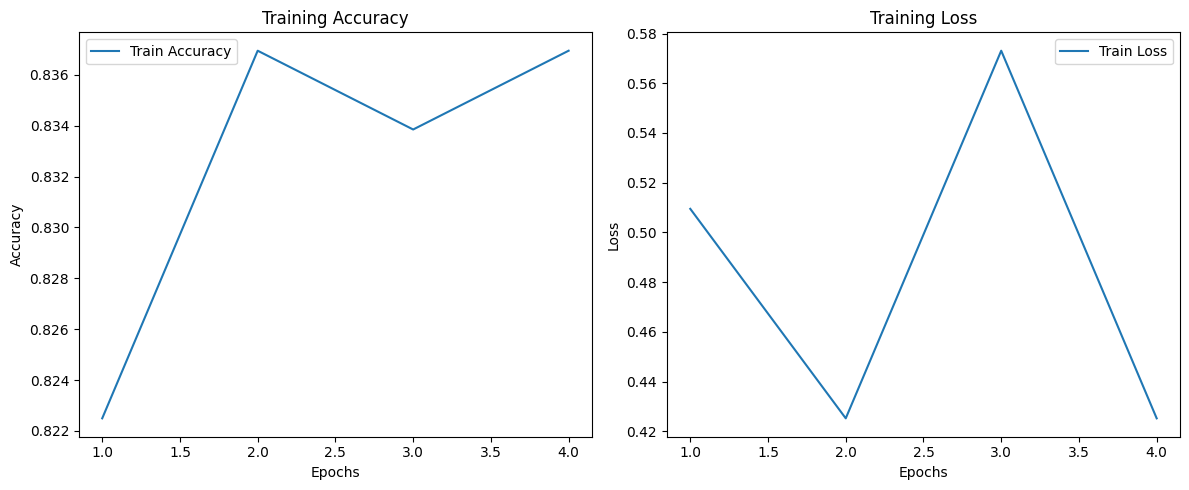

In [28]:
# Visualization of training results
history = trainer.state.log_history

# Extracting the relevant history data
train_acc = [x['eval_accuracy'] for x in history if 'eval_accuracy' in x]
train_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]
epochs = list(range(1, len(train_acc) + 1))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Model Saving

In [29]:
# Save the fine-tuned model
trainer.save_model('./fine_tuned_model')

# Model Testing

In [30]:
# Make predictions
def predict(text):
    encoding = tokenizer(text, return_tensors='pt', truncation=True, padding=True)

    # Move input tensors to the same device as the model
    input_ids = encoding['input_ids'].to(model.device)
    attention_mask = encoding['attention_mask'].to(model.device)

    outputs = model(input_ids, attention_mask=attention_mask)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    return torch.argmax(probs, dim=1).item()

In [31]:
labels = ['positive', 'neutral', 'negative']
messages = [
    "Congratulations! you have won a $1,000 Walmart gift card",
    "such massive asteroid hit will certainly create new business opportunities",
    "so does anyone else not open Snapchat anymore? or is it just me... ugh this so sad.",
    "@elonmusk had a terrible experience with a very pushy sales guy from tesla Stanford shop while shopping for model x",
    "The local electronics industry is expected to remain stable amid layoff concerns surrounding Japanese electronics giants operating in the country, an official says.",
    "The local electronics industry is amid layoff concerns and last year has laid off tens of employees"
]

for message in messages:
    sentiment = predict(message)
    print(f'Message: {message}\nSentiment: {labels[sentiment]}\n')

Message: Congratulations! you have won a $1,000 Walmart gift card
Sentiment: neutral

Message: such massive asteroid hit will certainly create new business opportunities
Sentiment: positive

Message: so does anyone else not open Snapchat anymore? or is it just me... ugh this so sad.
Sentiment: neutral

Message: @elonmusk had a terrible experience with a very pushy sales guy from tesla Stanford shop while shopping for model x
Sentiment: negative

Message: The local electronics industry is expected to remain stable amid layoff concerns surrounding Japanese electronics giants operating in the country, an official says.
Sentiment: negative

Message: The local electronics industry is amid layoff concerns and last year has laid off tens of employees
Sentiment: negative



# Lode Model and Testing

In [32]:
from transformers import BertForSequenceClassification, pipeline

# Load the fine-tuned model
model_path = 'fine_tuned_model'  # Path to your saved model
loaded_model = BertForSequenceClassification.from_pretrained(model_path)

# Create a pipeline for sentiment analysis (or your relevant task)
classifier = pipeline('sentiment-analysis', model=loaded_model.to('cuda'), tokenizer=tokenizer, top_k=None)


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [33]:
# Example test data
test_texts = [
    "This movie is absolutely fantastic!",
    "I had a terrible experience at that restaurant.",
    "The product is okay, nothing special."
]

# Perform inference on test data
results = classifier(test_texts)

# Print the results
for result in results:
    print(result)

[{'label': 'LABEL_1', 'score': 0.7587506175041199}, {'label': 'LABEL_0', 'score': 0.22476251423358917}, {'label': 'LABEL_2', 'score': 0.016486849635839462}]
[{'label': 'LABEL_2', 'score': 0.8572981953620911}, {'label': 'LABEL_1', 'score': 0.10714437067508698}, {'label': 'LABEL_0', 'score': 0.03555741906166077}]
[{'label': 'LABEL_1', 'score': 0.9509609341621399}, {'label': 'LABEL_0', 'score': 0.0423225462436676}, {'label': 'LABEL_2', 'score': 0.006716509815305471}]
